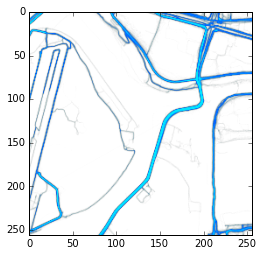

[]

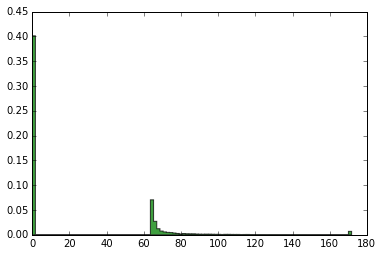

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy.misc import imread
import requests as r
import math

def rgb2gray(rgb):
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.144])

# http://globalheat.strava.com/tiles/cycling/color4/13/4948/2560.png
x, y, z = 4948, 2560, 13
url = "http://globalheat.strava.com/tiles/cycling/color3/%d/%d/%d.png" % (z, x, y)

ret = r.get(url)
filename = 'tmp.png'
chunk_size=1024
with open(filename, 'wb') as fd:
    for chunk in ret.iter_content(chunk_size):
        fd.write(chunk)

tile = imread(filename)        
plt.imshow(tile)     
plt.show()

gray = rgb2gray(tile)

# gray.flatten()
# hist, bin_edges = np.histogram(gray.flatten(), density=True)
plt.hist(gray.flatten(), 100, normed=1, histtype='stepfilled', facecolor='g', alpha=0.75)
plt.plot()